In [23]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.layers import Conv2D, MaxPooling2D,Activation
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import keras_cv
from keras_cv import utils
from keras_cv.layers import BaseImageAugmentationLayer

import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
import glob
import sys

import cv2

import matplotlib.pyplot as plt
from matplotlib import gridspec

In [24]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [25]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [26]:
class RandomColorDistortion(tf.keras.layers.Layer):
    def __init__(self, contrast_range=[0.5, 1.5], 
        brightness_delta=[-0.2, 0.2], **kwargs):
        super(RandomColorDistortion, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.brightness_delta = brightness_delta
        self.auto_vectorize = False
    
    def call(self, images, training=None):
        if not training:
            return images
        
        contrast = np.random.uniform(
            self.contrast_range[0], self.contrast_range[1])
        brightness = np.random.uniform(
            self.brightness_delta[0], self.brightness_delta[1])
        
        images = tf.image.adjust_contrast(images, contrast)
        images = tf.image.adjust_brightness(images, brightness)
        images = tf.clip_by_value(images, 0, 1)
        return images

class random_zoom_layer(tf.keras.layers.Layer):
    def __init__(self, probability=0.5, **kwargs):
        super().__init__(**kwargs)
        self.probability = probability
        self.layer = tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='constant')

    def call(self, x):
        return tf.cond(tf.less(tf.random.uniform([]), self.probability), lambda: self.layer(x), lambda: x)

class RandomMultiply(keras_cv.layers.BaseImageAugmentationLayer):
    """RandomBlueTint randomly applies a blue tint to images.

    Args:
      factor: A tuple of two floats, a single float or a
        `keras_cv.FactorSampler`. `factor` controls the extent to which the
        image is blue shifted. `factor=0.0` makes this layer perform a no-op
        operation, while a value of 1.0 uses the degenerated result entirely.
        Values between 0 and 1 result in linear interpolation between the original
        image and a fully blue image.
        Values should be between `0.0` and `1.0`.  If a tuple is used, a `factor` is
        sampled between the two values for every image augmented.  If a single float
        is used, a value between `0.0` and the passed float is sampled.  In order to
        ensure the value is always the same, please pass a tuple with two identical
        floats: `(0.5, 0.5)`.
    """

    def __init__(self, factor, **kwargs):
        super().__init__(**kwargs)
        self.factor = utils.parse_factor(factor)
        # this disables BaseImageAugmentationLayer's Auto Vectorization
        self.auto_vectorize = False

    def get_random_transformation(self, **kwargs):
        # kwargs holds {"images": image, "labels": label, etc...}
        return self.factor()

    def augment_image(self, image, transformation=None, **kwargs):
        image = image / 255
        image1 = image * image
        image = image * 255
        # [*others, blue] = tf.unstack(image, axis=-1)
        tf.clip_by_value(image, 0.0, 255.0)
        return image

    def augment_bounding_boxes(self, bounding_boxes, transformation=None, **kwargs):
        # you can also perform no-op augmentations on label types to support them in
        # your pipeline.
        return bounding_boxes

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        # RandomMultiply(factor=1),
    ]
)

In [27]:
inputs = keras.Input(shape=(32,32,3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32,64,128,256]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])


x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(100, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_3 (Rescaling)        (None, 32, 32, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 28, 28, 32)   2400        ['rescaling_3[0][0]']            
                                                                                                  
 batch_normalization_24 (BatchN  (None, 28, 28, 32)  128         ['conv2d_15[0][0]']              
 ormalization)                                                                              

In [28]:
opt = tf.optimizers.Adam(learning_rate=0.0001)

In [29]:
model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [30]:
callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="test.keras",
save_best_only=True,
monitor="val_loss")
]

In [31]:
history = model.fit(
x_train, y_train,
epochs=80,
batch_size=64,
validation_data=(x_test, y_test),
callbacks=callbacks)

Epoch 1/80


2022-10-13 15:00:31.155425: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.0KiB (rounded to 131072)requested by op Fill
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-10-13 15:00:31.155465: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2022-10-13 15:00:31.155476: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 239, Chunks in use: 239. 59.8KiB allocated for chunks. 59.8KiB in use in bin. 26.7KiB client-requested in use in bin.
2022-10-13 15:00:31.155483: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 80, Chunks in use: 80. 41.5KiB allocated for chunks. 41.5KiB in use in bin. 38.9KiB client-requested in use in bin.
2022-10-13 15:00:31.155489: I ten

ResourceExhaustedError: in user code:

    File "/usr/lib/python3/dist-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/usr/lib/python3/dist-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/lib/python3/dist-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/usr/lib/python3/dist-packages/keras/engine/training.py", line 893, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/usr/lib/python3/dist-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 539, in minimize
        return self.apply_gradients(grads_and_vars, name=name)
    File "/usr/lib/python3/dist-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 646, in apply_gradients
        self._create_all_weights(var_list)
    File "/usr/lib/python3/dist-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 860, in _create_all_weights
        self._create_slots(var_list)
    File "/usr/lib/python3/dist-packages/keras/optimizers/optimizer_v2/adam.py", line 122, in _create_slots
        self.add_slot(var, 'm')
    File "/usr/lib/python3/dist-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 946, in add_slot
        weight = tf.Variable(
    File "/usr/lib/python3/dist-packages/keras/initializers/initializers_v2.py", line 152, in __call__
        return tf.zeros(shape, dtype)

    ResourceExhaustedError: OOM when allocating tensor with shape[256,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill]


### Highest Val Accuracy = 39.9%

In [ ]:
from hdr_blend import*

In [ ]:
end = len(x_train)

x_dataAug = []
y_dataAug = []
for image in range(0,end):
    x_dataAug.append(hdr(x_train[image]))
    y_dataAug.append(y_train[image])
 

In [ ]:
y_dataAug = np.asarray(y_dataAug)
x_dataAug = np.asarray(x_dataAug)

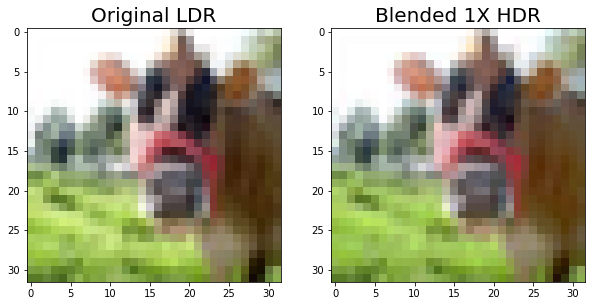

In [ ]:
# Show images. 
fig = plt.figure(figsize = (10,20))
columns = 2
rows = 1
fig.add_subplot(rows,columns, 1)
plt.imshow(x_train[0])
plt.title('Original LDR', fontdict={'fontsize': 20})
fig.add_subplot(rows,columns, 2)
plt.imshow(x_dataAug[0])
plt.title('Blended 1X HDR', fontdict={'fontsize': 20})
plt.show()

In [ ]:
len(x_dataAug)
len(y_dataAug)

50000

In [ ]:
inputs = keras.Input(shape=(32,32,3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32,64,128,256]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])


x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(100, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_11 (Rescaling)       (None, 32, 32, 3)    0           ['input_12[0][0]']               
                                                                                                  
 conv2d_66 (Conv2D)             (None, 28, 28, 32)   2400        ['rescaling_11[0][0]']           
                                                                                                  
 batch_normalization_94 (BatchN  (None, 28, 28, 32)  128         ['conv2d_66[0][0]']              
 ormalization)                                                                             

In [ ]:
model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="cifar100_feature_extraction_with_data_augmentation.keras",
save_best_only=True,
monitor="val_loss")
]

In [ ]:
history = model.fit(
x_dataAug, y_dataAug,
epochs=80,
batch_size=64,
validation_data=(x_test, y_test),
callbacks=callbacks)

Epoch 1/80
782/782 [==============================] - 5s 6ms/step - loss: 4.2082 - accuracy: 0.0627 - val_loss: 3.8395 - val_accuracy: 0.1264
Epoch 2/80
782/782 [==============================] - 4s 5ms/step - loss: 3.8474 - accuracy: 0.1094 - val_loss: 3.5755 - val_accuracy: 0.1692
Epoch 3/80
782/782 [==============================] - 4s 5ms/step - loss: 3.6768 - accuracy: 0.1318 - val_loss: 3.4109 - val_accuracy: 0.1936
Epoch 4/80
782/782 [==============================] - 4s 5ms/step - loss: 3.5466 - accuracy: 0.1536 - val_loss: 3.3862 - val_accuracy: 0.1891
Epoch 5/80
782/782 [==============================] - 4s 5ms/step - loss: 3.4371 - accuracy: 0.1708 - val_loss: 3.2195 - val_accuracy: 0.2220
Epoch 6/80
782/782 [==============================] - 4s 6ms/step - loss: 3.3379 - accuracy: 0.1884 - val_loss: 3.1177 - val_accuracy: 0.2392
Epoch 7/80
782/782 [==============================] - 4s 6ms/step - loss: 3.2639 - accuracy: 0.1992 - val_loss: 3.0523 - val_accuracy: 0.2516
Epoch 

### Highest Validation Accuracy: 39.44%.  One pass through HDR. 

In [ ]:
end = len(x_dataAug)

x_dataAug_2 = []
y_dataAug_2 = []
for image in range(0,end):
    x_dataAug_2.append(hdr(x_dataAug[image]))
    y_dataAug_2.append(y_train[image])
 

In [ ]:
y_dataAug_2 = np.asarray(y_dataAug)
x_dataAug_2 = np.asarray(x_dataAug)

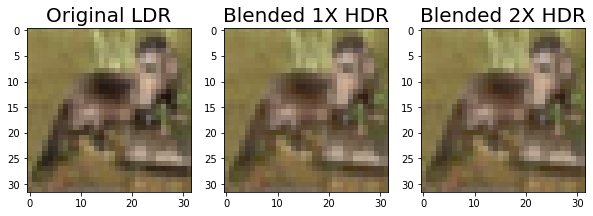

In [ ]:
# Show images. 
fig = plt.figure(figsize = (10,30))
columns = 3
rows = 1
fig.add_subplot(rows,columns, 1)
plt.imshow(x_train[0])
plt.title('Original LDR', fontdict={'fontsize': 20})
fig.add_subplot(rows,columns, 2)
plt.imshow(x_dataAug[0])
plt.title('Blended 1X HDR', fontdict={'fontsize': 20})
fig.add_subplot(rows,columns, 3)
plt.imshow(x_dataAug_2[0])
plt.title('Blended 2X HDR', fontdict={'fontsize': 20})
plt.show()

In [ ]:
inputs = keras.Input(shape=(32,32,3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32,64,128,256]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])


x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(100, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_12 (Rescaling)       (None, 32, 32, 3)    0           ['input_13[0][0]']               
                                                                                                  
 conv2d_71 (Conv2D)             (None, 28, 28, 32)   2400        ['rescaling_12[0][0]']           
                                                                                                  
 batch_normalization_102 (Batch  (None, 28, 28, 32)  128         ['conv2d_71[0][0]']              
 Normalization)                                                                            

In [ ]:
model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="cifar100_feature_extraction_with_data_augmentation2X.keras",
save_best_only=True,
monitor="val_loss")
]

In [ ]:
history = model.fit(
x_dataAug_2, y_dataAug_2,
epochs=80,
batch_size=64,
validation_data=(x_test, y_test),
callbacks=callbacks)

Epoch 1/80
782/782 [==============================] - 5s 6ms/step - loss: 4.2247 - accuracy: 0.0595 - val_loss: 3.8486 - val_accuracy: 0.1183
Epoch 2/80
782/782 [==============================] - 4s 5ms/step - loss: 3.8677 - accuracy: 0.1067 - val_loss: 3.5953 - val_accuracy: 0.1564
Epoch 3/80
782/782 [==============================] - 4s 5ms/step - loss: 3.6994 - accuracy: 0.1284 - val_loss: 3.4667 - val_accuracy: 0.1783
Epoch 4/80
782/782 [==============================] - 4s 5ms/step - loss: 3.5652 - accuracy: 0.1497 - val_loss: 3.3374 - val_accuracy: 0.2012
Epoch 5/80
782/782 [==============================] - 4s 5ms/step - loss: 3.4604 - accuracy: 0.1685 - val_loss: 3.2483 - val_accuracy: 0.2162
Epoch 6/80
782/782 [==============================] - 4s 5ms/step - loss: 3.3706 - accuracy: 0.1822 - val_loss: 3.1881 - val_accuracy: 0.2296
Epoch 7/80
782/782 [==============================] - 4s 5ms/step - loss: 3.2939 - accuracy: 0.1975 - val_loss: 3.1154 - val_accuracy: 0.2413
Epoch 

### Highest Validation Accuracy: 39.40%.  Two passes through HDR. 

In [ ]:
#How many elements are in that data. 
print(x_train.size)

#What is the shape of the array.
print(x_train.shape)

#What type are the elements.
print(x_train.dtype)

#How many elements are in that data. 
print(x_dataAug_2.size)

#What is the shape of the array.
print(x_dataAug_2.shape)

#What type are the elements.
print(x_dataAug_2.dtype)


153600000
(50000, 32, 32, 3)
uint8
153600000
(50000, 32, 32, 3)
uint8


In [ ]:
x_full = np.concatenate((x_train, x_dataAug_2))
y_full = np.concatenate((y_train, y_dataAug_2))

In [ ]:
print(x_full.shape)

(100000, 32, 32, 3)


In [ ]:
inputs = keras.Input(shape=(32,32,3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32,64,128,256]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])


x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(100, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_13 (Rescaling)       (None, 32, 32, 3)    0           ['input_14[0][0]']               
                                                                                                  
 conv2d_76 (Conv2D)             (None, 28, 28, 32)   2400        ['rescaling_13[0][0]']           
                                                                                                  
 batch_normalization_110 (Batch  (None, 28, 28, 32)  128         ['conv2d_76[0][0]']              
 Normalization)                                                                            

In [ ]:
model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="cifar100_feature_extraction_with_data_augmentation_fullDS.keras",
save_best_only=True,
monitor="val_loss")
]

In [ ]:
history = model.fit(
x_full, y_full,
epochs=80,
batch_size=64,
validation_data=(x_test, y_test),
callbacks=callbacks)

Epoch 1/80
1563/1563 [==============================] - 9s 5ms/step - loss: 4.0324 - accuracy: 0.0831 - val_loss: 3.5463 - val_accuracy: 0.1706
Epoch 2/80
1563/1563 [==============================] - 8s 5ms/step - loss: 3.5902 - accuracy: 0.1485 - val_loss: 3.2915 - val_accuracy: 0.2133
Epoch 3/80
1563/1563 [==============================] - 8s 5ms/step - loss: 3.3778 - accuracy: 0.1827 - val_loss: 3.1721 - val_accuracy: 0.2281
Epoch 4/80
1563/1563 [==============================] - 9s 5ms/step - loss: 3.2148 - accuracy: 0.2103 - val_loss: 3.0150 - val_accuracy: 0.2572
Epoch 5/80
1563/1563 [==============================] - 8s 5ms/step - loss: 3.0813 - accuracy: 0.2361 - val_loss: 2.8813 - val_accuracy: 0.2815
Epoch 6/80
1563/1563 [==============================] - 8s 5ms/step - loss: 2.9695 - accuracy: 0.2553 - val_loss: 2.9046 - val_accuracy: 0.2829
Epoch 7/80
1563/1563 [==============================] - 9s 5ms/step - loss: 2.8628 - accuracy: 0.2745 - val_loss: 2.7153 - val_accuracy:

### Highest Val Accuracy: 41.76%.  Almost 2% better accuracy when combining original dataset with blended dataset. 

In [ ]:
x_train_2X = np.concatenate((x_train, x_train))
y_train_2X = np.concatenate((y_train, y_train))

In [ ]:
inputs = keras.Input(shape=(32,32,3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32,64,128,256]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])


x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(100, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_14 (Rescaling)       (None, 32, 32, 3)    0           ['input_15[0][0]']               
                                                                                                  
 conv2d_81 (Conv2D)             (None, 28, 28, 32)   2400        ['rescaling_14[0][0]']           
                                                                                                  
 batch_normalization_118 (Batch  (None, 28, 28, 32)  128         ['conv2d_81[0][0]']              
 Normalization)                                                                            

In [ ]:
model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="cifar100_feature_extraction_without_data_augmentation_DS2X.keras",
save_best_only=True,
monitor="val_loss")
]

In [ ]:
history = model.fit(
x_train_2X, y_train_2X,
epochs=80,
batch_size=64,
validation_data=(x_test, y_test),
callbacks=callbacks)

Epoch 1/80
1563/1563 [==============================] - 9s 5ms/step - loss: 4.0519 - accuracy: 0.0807 - val_loss: 3.6024 - val_accuracy: 0.1607
Epoch 2/80
1563/1563 [==============================] - 8s 5ms/step - loss: 3.6292 - accuracy: 0.1392 - val_loss: 3.3436 - val_accuracy: 0.2066
Epoch 3/80
1563/1563 [==============================] - 8s 5ms/step - loss: 3.4199 - accuracy: 0.1757 - val_loss: 3.1548 - val_accuracy: 0.2374
Epoch 4/80
1563/1563 [==============================] - 8s 5ms/step - loss: 3.2517 - accuracy: 0.2035 - val_loss: 3.0417 - val_accuracy: 0.2553
Epoch 5/80
1563/1563 [==============================] - 8s 5ms/step - loss: 3.1044 - accuracy: 0.2307 - val_loss: 2.8926 - val_accuracy: 0.2870
Epoch 6/80
1563/1563 [==============================] - 7s 5ms/step - loss: 2.9737 - accuracy: 0.2528 - val_loss: 2.7940 - val_accuracy: 0.2963
Epoch 7/80
1563/1563 [==============================] - 8s 5ms/step - loss: 2.8680 - accuracy: 0.2718 - val_loss: 2.7598 - val_accuracy:

### Highest Val Accuracy: 40.40%. The combonation of the blended and origanal dataset was 1.25% better than the original dataset doubled. 

In [ ]:
data_augmentation = keras.Sequential(
[
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.1),
]
)

In [ ]:
inputs = keras.Input(shape=(32,32,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32,64,128,256]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])


x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(100, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential_6 (Sequential)      (None, 32, 32, 3)    0           ['input_20[0][0]']               
                                                                                                  
 rescaling_19 (Rescaling)       (None, 32, 32, 3)    0           ['sequential_6[1][0]']           
                                                                                                  
 conv2d_106 (Conv2D)            (None, 28, 28, 32)   2400        ['rescaling_19[0][0]']           
                                                                                           

In [ ]:
model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="cifar100_feature_extraction_without_data_augmentation_fullds_classic.keras",
save_best_only=True,
monitor="val_loss")
]

In [ ]:
history = model.fit(
x_full, y_full,
epochs=200,
batch_size=64,
validation_data=(x_test, y_test),
callbacks=callbacks)

Epoch 1/200
1563/1563 [==============================] - 30s 18ms/step - loss: 4.0968 - accuracy: 0.0734 - val_loss: 3.6703 - val_accuracy: 0.1474
Epoch 2/200
1563/1563 [==============================] - 28s 18ms/step - loss: 3.7326 - accuracy: 0.1221 - val_loss: 3.5050 - val_accuracy: 0.1681
Epoch 3/200
1563/1563 [==============================] - 28s 18ms/step - loss: 3.5729 - accuracy: 0.1486 - val_loss: 3.3526 - val_accuracy: 0.1881
Epoch 4/200
1563/1563 [==============================] - 27s 17ms/step - loss: 3.4479 - accuracy: 0.1704 - val_loss: 3.2298 - val_accuracy: 0.2100
Epoch 5/200
1563/1563 [==============================] - 32s 21ms/step - loss: 3.3486 - accuracy: 0.1870 - val_loss: 3.0836 - val_accuracy: 0.2400
Epoch 6/200
1563/1563 [==============================] - 28s 18ms/step - loss: 3.2641 - accuracy: 0.2037 - val_loss: 3.0809 - val_accuracy: 0.2425
Epoch 7/200
1563/1563 [==============================] - 31s 20ms/step - loss: 3.1849 - accuracy: 0.2185 - val_loss: 3

In [ ]:
inputs = keras.Input(shape=(32,32,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32,64,128,256]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])


x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(100, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential_6 (Sequential)      (None, 32, 32, 3)    0           ['input_21[0][0]']               
                                                                                                  
 rescaling_20 (Rescaling)       (None, 32, 32, 3)    0           ['sequential_6[2][0]']           
                                                                                                  
 conv2d_111 (Conv2D)            (None, 28, 28, 32)   2400        ['rescaling_20[0][0]']           
                                                                                           

In [ ]:
model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="cifar100_feature_extraction_without_data_augmentation_DS2X_classic.keras",
save_best_only=True,
monitor="val_loss")
]

In [ ]:
history = model.fit(
x_train_2X, y_train_2X,
epochs=200,
batch_size=64,
validation_data=(x_test, y_test),
callbacks=callbacks)

Epoch 1/200
1563/1563 [==============================] - 30s 19ms/step - loss: 4.0719 - accuracy: 0.0774 - val_loss: 3.6722 - val_accuracy: 0.1452
Epoch 2/200
1563/1563 [==============================] - 30s 19ms/step - loss: 3.7140 - accuracy: 0.1235 - val_loss: 3.4796 - val_accuracy: 0.1701
Epoch 3/200
1563/1563 [==============================] - 27s 17ms/step - loss: 3.5449 - accuracy: 0.1506 - val_loss: 3.3349 - val_accuracy: 0.1970
Epoch 4/200
1563/1563 [==============================] - 30s 19ms/step - loss: 3.4206 - accuracy: 0.1728 - val_loss: 3.2317 - val_accuracy: 0.2146
Epoch 5/200
1563/1563 [==============================] - 33s 21ms/step - loss: 3.3121 - accuracy: 0.1937 - val_loss: 3.1575 - val_accuracy: 0.2262
Epoch 6/200
1563/1563 [==============================] - 29s 18ms/step - loss: 3.2266 - accuracy: 0.2086 - val_loss: 2.9662 - val_accuracy: 0.2660
Epoch 7/200
1563/1563 [==============================] - 29s 18ms/step - loss: 3.1575 - accuracy: 0.2218 - val_loss: 2

: 

: 